

# Bacterial bomb
## 1. Introduction

This is an assessed project as part of Geog5003M at the University of Leeds.

The project involves tracking the fallout from an imaginary biological bomb that has been set off in an urban area. The aim is to read in a file which identifies where the bomb has been set off and then to track the spread of the particles and map where they land. This is a probability based approach where the direction and altitude of each particle depends on windspeed and height. 

The basic code maps the particles onto a flat plain surface. The project is then extended by enabling the user to choose the number of particles, the windspeed and to have the particles landing on a contoured surface or digital elevation model. 

The code is written in python and runs within this Jupyter notebook. It can also be run at the command line. It has a GUI. When the code is run in this notebook it opens a GUI window and the user has to complete the various options and close this window for the model to run.

## 1.1 How this notebook is organised

Index
 1 Introduction
 2 Walking through the model step by step
 3 Moving particles (in associated file particlemove.py)
 4 Testing and Timing
 5 Examining output
 6 Conclusions

The completed final model is also saved in the GitHub repositary along with the associated files needed to run it. The file is best run at the command line. 

## 1.2 How the code was developed

The basic algorithmn given in the instructions was followed and the basic structure of the code is similar to an earlier piece of work on agent based modelling. The basic strucure has a main file (bacterialbomb.py) and an associated file for a class of particles (particlemove.py). Initially the logic for particle movement was developed for a single particle and once it was working it was developed as a method for the class of particles. Then the particles were recorded where they land and this data was mapped into a density map.

The basic model was then further developed by including a GUI with some user choices. Some complexity was added by considering how the particles would land on a surface that was not flat. This means that on each iteration one needs to consider the height of the particle and the height of the land at that point.  

## 1.3 Challenges encountered

The main challenge was how to present the data in a density map using matplotlib whilst also showing the terrain in the digital elevation model.The solution was a hybrid plot using a filled contour plot for the elevation and marking particles with dots that were coloured based on the number of particles at that location. 

There were also a number of minor technical challenges around developing the GUI, having the code structure work in a Jupter Notebook, accessing the data using Beautiful Soup.

## 1.5 Areas for further development

There are two possible areas for further development.
1. Allowing the user to choose the wind direction. 
This model has the predominant wind from the East. The model could allow the user to choose the wind direction. However the modeled surface would need to be extended in size otherwise particles would move off the edge of the area.
2. Modelling the effects of a rainstorm
Another development would be to consider how the particles might flow from their landing point in event being of washed away in a rainstorm. In order to do this one would need to consider the height of each cell and its 8 neighbours to establish in which direction the water (and therefore particles) would flow. This is quite complex because many cells are the same height as their neighbours.

## 2 Walking through the model step by step

### 2.1 Basic algorithmn

The approach to be taken is as follows;
1. Setting up a GUI
2. Reading the data from the website, converting the raster to a 2D list and identify the location of the bomb
3. Build the prediction logic for a single particle
4. Develop the model so that 5000 particles can be run through the same logic
5. Record where each of the 5000 particles land
6. Develop a density map of where the particles land
7. Save the density map to a file as text

### 2.2 Setting up the imports, variables and lists

This section of code includes the imported libraries of functions and creates some global variables and lists used later in the code.

In [1]:
# Imports
import matplotlib.pyplot
import csv
from bs4 import BeautifulSoup
import requests
import particlemove # Associated file used to move particles
import tkinter as tk
import time


# Model variables
num_of_iterations = 200  # This no. allows all particles to land in high wind
num_of_particles = 0  # This creates the object it is updated in the GUI
wind_speed = 0  # This is updated in the GUI 


# Creating lists
particles = [] #Used to hold particle data
citydata = [] #Used to hold bombsite and then particle landing position data
environment = [] #Used to hold a digital elevation model

# Start a timer to time the code
start = time.time() #Used for measuring how long it takes at the end


### 2.3 Creating a GUI

A graphical user interface ("GUI") has been developed allowing the user to choose options. There are three choices to be made - the number of particles, the windspeed and the surface that the particles land on.

The recommended number of particles is 5000 although, as you will see in the output, it is common to have individual particles landing some distance from the main landing area. If the user is concerned about this then the model could be run multiple times or the number of particles increased to have a clear understanding of the potential landing range under different circumstances.The landing zone is also highly susceptible to changes in assumptions about particle movement. If there is some uncertainty about these parameters then a more cautious approach would be to consider a wider area to be the "danger zone" and not just the areas where particles are modelled to land.

The windspeed can be varied. This influences both the turbulence when the particles are high and the distance particles can travel in the direction of the prevailing wind.

The basic model considers the particles landing on a flat surface. In real life surfaces are not usually flat so there is also the option to choose a contoured surface and see how this influences the landing zone.

The GUI includes a help function for each of the user options.

In [2]:
# Setting up GUI, this part of the code runs before main() at the bottom
# The overall strucutre and some elements of the GUI were developed based 
# on tutorials under the name The New Boston found on You Tube (see references)

# This is the routine that runs when the user clicks the run button
def routine():
    """The function called by pressing Run in the GUI, collects user inputs"""
    global num_of_particles  # Used in other functions so made global
    num_of_particles = int(my_entry.get())
    print("The number of particles is", num_of_particles)
    global wind_speed  
    wind_speed = int(scale_widget.get())
    print("The wind speed is ", wind_speed)
    global topography  # Used to select the type of surface or basemap
    topography = str(listbox_widget.get(tk.ANCHOR))
    print("The model uses a", topography)
 
# The functions below print help instructions when selected    
def particlehelp():
    """Prints some help relating to particle numbers when requested in GUI"""
    print("HELP")
    print("The number of particles chosen will influence the speed")
    print("5000 particles will typically take about 5 seconds")
    print("If you are interested in rare events where particles land far from")
    print("the main landing area then you may want to use more particles")
       
def windspeedhelp():
    """Prints some help relating to windspeed when requested in the GUI"""
    print("HELP")
    print("The higher windspeed causes more turbulence")
    print("Resulting in particles being more dispersed")
    print("The wind direction is fixed as Easterly")
    print("In strong wind (above 6) the particles are blown further East")

def surfacehelp():
    """Prints some help relating to the surface choice when requested in GUI"""
    print("HELP")
    print("The basic model assumes a uniform flat surface or flat plain")
    print("The digital elevation model uses a contoured surface")
    print("The contoured surface used slopes down in an Easterly direction")
    print("This means that particles travel further using the DEM")    
        
# Set up the GUI window and size    
root = tk.Tk()
root.geometry("500x300")
root.title("Bacterial Bomb") #Add a title to the GUI window  

# Add a menu with help function
# Source: https://www.youtube.com/watch?v=PSm-tq5M-Dc
menu1 = tk.Menu(root)
root.config(menu=menu1)
subMenu = tk.Menu(menu1)
menu1.add_cascade(label="Help", menu=subMenu)
subMenu.add_command(label="Particle choice", command=particlehelp)
subMenu.add_command(label="Windspeed", command=windspeedhelp)
subMenu.add_command(label= "Surface", command=surfacehelp)

# Add a button used for running the program, routine run when button clicked 
button1 = tk.Button(root, text ="Run", command=routine)
button1.grid(row=6, column=0)

# Add a label above the entry box
label2 = tk.Label(root, text="Enter number of particles: 5000 recommended")
label2.grid(row=2, column=4, padx=5, pady=5)

# Add an entry box used for number of particles
my_entry = tk.Entry(root, width=15)
my_entry.grid(row=3, column=4)

# Add a label above the scale widget
label3 = tk.Label(root, text="Enter wind speed (beaufort scale)")
label3.grid(row=4, column=4)

# Add a scale widget for windspeed
# Source: dummies.com/programming/python/using-tkinter-widgets-in-python/
scale_widget = tk.Scale(root, from_=0, to=12, orient=tk.HORIZONTAL)
scale_widget.set(4)
scale_widget.grid(row=5, column=4)

# Add a label above the scale widget
label4 = tk.Label(root, text="Enter the type of surface")
label4.grid(row=7, column=4)

# Add a drop down box for choosing the type of surface
listbox_entries = ["Flat plain", "Digital elevation model"]
listbox_widget = tk.Listbox(root, height=2, width=25)
for entry in listbox_entries:
    listbox_widget.insert(tk.END, entry)
listbox_widget.grid(row=8, column=4, padx=5, pady=5)

textbox = tk.Text(root,height=4, width=20, padx=5,
                  pady=5, font=("Helvetica",10))
textbox.insert(
    tk.END,"INSTRUCTIONS\nChoose parameters\nPress Run\nClose this window\n")
textbox.grid(row=0, column=0, padx=5, pady=5)


root.mainloop()# GUI window keeps running until it is closed 


The number of particles is 5000
The wind speed is  11
The model uses a Digital elevation model


### 2.4 Scraping the bomb site data and loading the environment data

The wind raster file is scraped from a University of Leeds website. The data is extracted using Beautiful Soup and saved to a text file (city.txt). This file is then opened and read and converted to a list (citydata). The last line is deleted as it is not needed. This process of saving then re-reading a file seems inefficient. There is probably a better way to do this.

In addition another file (in.txt) is read and saved as a list (environment). This is the file used for the digital elevation model. This part of the code is copied from the earlier agents based model.  

In [3]:
# Scraping data from the web to identify bomb location (need to be online)
# Website address line is too long but could not make it work splitting it up
def getdata():
    """Scrapes file with the bomb site from the web and saves it as citydata"""
    city = []
    url ="http://www.geog.leeds.ac.uk/courses/computing/study/core-python-odl2/assessment2/wind.raster"
    html_content = requests.get(url).text
    soup = BeautifulSoup(html_content, "lxml")
    city = soup.find_all("p")
# Save beautiful soup resultset as text file to access the individual numbers
# Saving to a file then reading that file seems rather inefficent
# Need to find a better way to access the data using BeautifulSoup
    with open('city.txt', 'w') as testfile:
        for row in city:
            testfile.write(' '.join([str(a) for a in row]) + '\n')

# This code opens the text file and defines the reader, the new line separator
# in the dataset, and the format of the data with one decimal place.
# Code mainly copied from agent based model work. 
    f = []
    f = open('city.txt', newline='\n')
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader: #Fill the list with 2D data row by row
        citydata.append(row)
    del citydata[300]  # Deletes a fragment of html syntax
    f.close() 
    #print(citydata[0]) #Testing prints
    #print(len(citydata))#Expecting 300 items, but gives 301
    #print(citydata[300]) #Check what is the last item to make 301
    #del citydata[300] #Deletes a fragment of html syntax
    #print(len(citydata)) #We now have a list with data for a 300x300 frame

# This code reads an environment data file to use as a DEM basemap.
# Then, if chosen, instead of landing on flat surface particles land on a DEM.
# This code is copied from agent based model work.
def getenvironment():
    """Reads a file with a contoured surface and saves it as environment"""
    file = []
    file = open('in.txt', newline='')
    reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:  # Fill the list with 2D data row by row
        environment.append(row)
    file.close() 
# Find height of land at bomb site
# Particle assumed to be released from height of building + height of land 
    #print(environment[150][50]) # Land is 200m at bomb site


# Plot the data for intial exploration
#matplotlib.pyplot.imshow(citydata)
#matplotlib.pyplot.axis([0,299,0,299])
#matplotlib.pyplot.show() # Appears to be data around x50 y150



### 2.5 Initial examination of the data and finding the bomb location

Searching through the citydata list it is a raster with zero in all cells except one which has the number 255 to identify the bombsite. The bombsite coordinates are saved as global variables to be used as the intial x and y coordinates for the particles. 

In [4]:
# This code identifies the bomb site 
def findbomb():
    """Indentifies the x and y coordinates of the bomb site"""
    for i in range (len(citydata)):
        for j in range (len(citydata[i])):
            if citydata[i][j]>0:
                #print(citydata[i][j])
                global xb
                global yb
                xb = j  # The coordinates of the bomb                
                yb = i 
                
# So now we know that there is a single bombsite at location x50,y150.
# It is marked by the number 255, whilst all other cells have zero


### 2.6 Creating particles
In this section we create identical particles which are subsequently moved using the methods in an associated file.

Each particle has an x, y and z (height) attribute as well as the windspeed and an ability to see the DEM in the environment list.

The initial particle height is 76m for a flat plain surface (75m building plus 1m for a person standing on top).
The land at the bomb site has an elevation of 200m so when a DEM is used the initial particle height is 276m.

In [5]:
# This function creates particles used in function below
# Assume a human stands on the building to release particles 1m above roof
# If "Flat plain" is selected particle height is 75m plus 1m = 76m
# If "DEM" is selected particle height is 200m + 76m = 276m  
def createparticles():
    """Creates the number of particles specified in the GUI"""
    if topography == "Digital elevation model": #Selected in GUI
        z = 276 # The elevation in the DEM at the bomb site is 200m
    else:
        z = 76  
    
    for i in range(num_of_particles):
        x = xb
        y = yb
        ws = wind_speed
        particles.append(particlemove.Particle (x, y, z, ws, environment))
        #print(particles[i])  # Used for testing
        #print(particles[0].x)


### 2.7 Iterate particles
The code below iterates the particles through the methods in the particlemove.py file. 
There are separate methods for z movement (up or down), for assessing whether the particle has landed and for the xy coordinate movement. These methods are examined in more detail in section 3.


In [6]:
# This function iterates the particles through methods in particlemove.py
def iterateparticles():
    """Iterates particles through the move methods in particlemove.py"""
    for j in range(num_of_iterations):
        #print("Iteration")
        for i in range(num_of_particles):
            #print("Particle moving") 
            particles[i].zmove()  # Moves particles up or down
            particles[i].landing()  # Considers if the particle has landed
            particles[i].xymove()  # Moves particles x or y coordinates

        #for i in range(num_of_particles):
            #print(particles[i])



   ### 2.8 Plotting the results
   The results are plotted onto a density map.
   Initially the number of particles in each "cell" are counted. This is recorded in the citydata file. 
   For the flat plain surface a simple density map is plotted. With 5000 particles the highest numbers are typically around 80. However if you set 80 as the max this highlights these high areas but it is difficult to see the broader range of the landing zone. Therefore the map works better with a max of 40. To further highlight the range of the landing zone cells with a single particle have been highlighted with a white spot.     
A different map is developed for the DEM option. This shows the contours and then the particles are shown by different coloured dots. The ground falls away from the bomb site as the particles move East so they tend to travel further than on the flat plain. 

In [7]:
# Plot the data as a density map.
# Firstly record the number of particles in each cell of citydata
# Increment the citydata file for each particle landing
# Then plot this data as a density map
# Two mapping options based on Flat plain or DEM selection
def plotdata():
    """Records coordinates of each landing particle and plots a density map""" 
    #print("Plotting data")
    for i in range(num_of_particles):
        citydata[particles[i].y][particles[i].x] += 1  # Increment per particle 
    citydata[150][50] -= 255 #Set bomb site data to zero
    
    #for i in range(len(citydata)):
        #for j in range(len(citydata[i])):
            #if citydata[i][j]>60: #Used to examine the upper range of data
                #print("x ",i,"y ",j,"number ", citydata[i][j])

# If the user has chosen a Flat plain in the GUI the topography = Flat plain
    if topography == "Flat plain":
        #print("Flat plain")    
        # Vary the max in line below to see broad range or high central points
        matplotlib.pyplot.imshow(citydata, vmin=0,vmax=40)
        matplotlib.pyplot.colorbar(label="Particles")
        matplotlib.pyplot.title("Map showing distribution of particles",
                                fontdict=None, loc=None, pad = None, y = None)
        matplotlib.pyplot.text(45, 80, s="X marks the bomb site", fontsize=7)
        matplotlib.pyplot.text(
            45, 76,s="White dots mark cells where single particles landed",
            fontsize=7)
        matplotlib.pyplot.axis([45, 200, 100, 200])
        matplotlib.pyplot.scatter(50, 150, marker="x", linewidth=3, c="w")
        # Lines below add white dots where there is a single particle
        for i in range(len(citydata)):
            for j in range(len(citydata[i])):
                if citydata[i][j] == 1:
                    matplotlib.pyplot.scatter(j, i, s=0.3, c="w")
        matplotlib.pyplot.show()
            
    else: #If DEM has been chosen
        #print("Digital elevation model")
        matplotlib.pyplot.contourf(environment)
        matplotlib.pyplot.colorbar(label="Elevation")
        matplotlib.pyplot.title(
            "Map showing distribution of particles",
            fontdict=None, loc=None, pad=None, y=None)
        # Next two lines are too long, splitting them mad the plot look poor
        matplotlib.pyplot.text(45, 66, s="X marks the bomb site, White dots mark cells where single particles landed",fontsize=7)
        matplotlib.pyplot.text(45, 62, s="Pink dots mark cells where 2 to 15 particles landed, Red dots mark cells where more than 15 landed",            fontsize=7)
        matplotlib.pyplot.axis([45, 300, 80, 220])
        matplotlib.pyplot.scatter(50, 150, marker="x", linewidth=3, c="w")
        # Code below creates a scatter plot showing different intensities
        for i in range(len(citydata)):
            for j in range(len(citydata[i])):
                if citydata[i][j] > 15:
                    matplotlib.pyplot.scatter(j, i, s=0.3, c="r")
                elif citydata[i][j] > 1 <16:
                    matplotlib.pyplot.scatter(j, i, s=0.3, c="tab:pink")
                elif citydata[i][j] == 1:
                    matplotlib.pyplot.scatter(j, i, s=0.3, c="w")
        matplotlib.pyplot.show()


### 2.9 Saving the density map data
The code below saves the density map data to a text file. It over writes the previous data each time you run the model.


In [8]:
# Save the density map to a text file (Need to eliminate decimal place)
def savedata():
    """Saves the landed particle coordinates into a text file, citydata.txt"""
    with open('citydata.txt', 'w') as testfile:
        for row in citydata:
            testfile.write(' '.join([str(a) for a in row]) + '\n')



### 2.10 Organising the code into a main function

The code above is organised into functions. These functions are then run in the main function below producing the map as output.
There are two different formats for the map depending on surface chosen in the GUI.

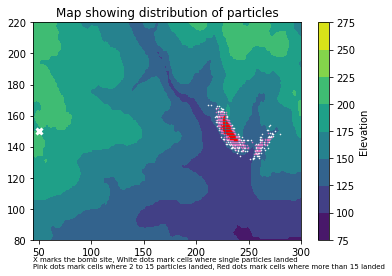

TIMING
Time elapsed 4.6609 seconds
End, file saved to citydata.txt


In [9]:
def main():
    """Runs the main functions and times the code"""
    mainstart = time.time()  #For timing the main program
    getdata()
    findbomb()
    getenvironment()
    createparticles()
    iterateparticles()
    plotdata()
    savedata()
    mainend = time.time()
    time_elapsed = mainend-mainstart
    print("TIMING")
    print ("Time elapsed", "%.4f" % time_elapsed,"seconds")
    print("End, file saved to citydata.txt")
        
main()

### 3 Moving the particles

The particles are moved using a class of particles and methods in an associated file particlemove.py
This section of code does not run properly in the Jupyter notebook because it is in a different file but it is working in the background when the main function is run above. 
For this reason an error message is produced below 3.2.1.

### 3.1 Setting up the class

The particles are set up using the arguments attributed to them in the create particles function.
Each particle also has a landed variable (which switches to 1 when it lands) and a variable where the intial height is stored.


In [10]:
import random

# Creating class
class Particle:
    """This class is used to iterate particles as they move"""    
    
    def __init__(self,x,y,z,ws,environment):
        """The particles set up in Bomb.py are identical on creation"""
        self.x = x
        self.y = y
        self.z = z
        self.ws = ws  #Stores windspeed
        self.environment = environment  # Stores digital elevation model
        self.landed = 0  # Switches to 1 when particle has landed
        self.refheight = z # This is the starting "z" 
    
        
    # Method used for printing particle details    
    def __str__(self):
        """Prints the key attributes of each particle, used for testing"""
        return (str("x")+ str(self.x)+
                " y"+str(self.y)+" z"+str(self.z)+ " Elevation "+
                str(self.environment[self.y][self.x]))
    

### 3.2 Particle methods used for moving

There are three separate methods - one for determining height movement, one for determining if the particle has landed and one for determining xy movement.


#### Height movement
The bacterial bomb has been released from a building that is 75m high.It is assumed that it is released by a human standing on top of the building so the actual height of release is 76m.

If the particle is above 75m then it has;

    - A 20% chance of rising by 1m
    - A 10% chance of staying the same level
    - A 70% chance of falling 1m.
At 75m and below it will simply fall by one metre per second.

This is modified to a 276m starting point where the digital elevation model is used so there is assumed to be no turbulence below 275m with this version. 

The windspeed selected by the user influences the level of turbulence. In higher windpeeds there will be more turbulence above 75m and if the particle rises or falls in turbulent conditions it rises or falls further. The ultimate impact of this is that particles will tend to be slightly more spread out. 


### 3.2.1 Height  movement method

In [12]:
     # Method used for moving particle up or down           
    def zmove(self):
        """Moves the height (or z) of each particle during 1 iteration"""
        # Defines a turbulence factor based on windspeed
        if self.ws > 8:
            turb = 3
        elif self.ws > 5:
            turb = 2
        elif self.ws > 3:
            turb = 1
        else:
            turb = 1
        #print ("Up/down cycle")
        # The up or down movement is amplified by higher turbulence
        if self.z> self.refheight-1:  # Up/down movement occurs above building
            #print("Above")
            rh = random.randint(0,9)  # Used for probability of up/down 
            #print ("rh= ",rh)
            if rh < 2:
                self.z += (1*turb)  # 20% chance going up 
                #print("Up",self.z)
            elif rh > 2:
                self.z -= (1*turb)  # 70% chance going down
                #print("Down",self.z)
            # if rh equals 2 there no change - 10% chance it stays same level
        else:  # Turbulence assumed not to apply at 75m and below
            if self.landed == 0: #This switches to 1 when the particle lands 
                self.z -= 1
                #print("Down", self.z)
            #else:
                #print("Landed", self.z)
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

### 3.2.2 Landed method

Each particle has an item called self.landed which starts as zero when the particle is created and switches to one when it lands. When it switches to 1 then the particle stops moving and its coordinates are fixed.

For the flat plain model this is fairly simple as you compare the particle height to zero. 

For the DEM this is more complex because you have to compare the particle height to the land surface height at that point. 

In [ ]:
  # Method used to assess whether the particle has landed    
    def landing(self):
        """Assesses whether the particle has landed or not on each iteration"""
        if self.refheight == 76:  # True where flat plain is selected in GUI
            if self.z ==0:  # When z is zero it has landed
                #print("Landed, coordinates fixed")
                #print("x ", self.x, "y ", self.y, "Height", self.z)
                #print("Elevation", self.environment[self.y][self.x])
                self.landed = 1  # Switches to landed so coordinates are fixed
        else: # Will be the case if DEM selected in GUI
            if self.z <= self.environment[self.y][self.x]:  # < Elevation
                self.z = self.environment[self.y][self.x]
                self.landed = 1  # Switches to landed to prevent further mvt.
            #print("Landed, coordinates fixed")
            #print("x ", self.x, "y ", self.y, "Height", self.z)
            #print("Elevation", self.environment[self.y][self.x])
     

### 3.2.3 X and Y movement method

    -There is a 5% chance the particle will blow west
    -A 10% chance of blowing North or South
    -A 75% chance of blowing East

Each iteration the particle will move one pixel on the screen.

Windspeed at 6 or above on the beaufort scale will lead to a particle moving in an Easterly direction travelling twice as far on each iteration. So this has the effect of moving the landing zone further East. 

In [ ]:
 # Method used to change the x and y coordinates until particle lands
    # Windpseed selected in GUI can amplify movement Eastwards     
    def xymove(self):
        """Moves the particle x and y coordinates on each iteration"""
        #print("XY Coordinate cycle)
        if self.landed == 1:
            #print("Landed, no xy move")
            self.x = self.x
        else:
            if self.ws > 6:  # Easterly movement multiplied at higher windspeed
                multiple = 2 
            else:
                multiple = 1                  
            rm = random.randint(0,19)
            #print ("rm =", rm)
            if rm == 0:
                self.x -= 1  # 5% chance of Westerly movement
            elif rm < 3:
                self.y += 1  # 10% chance of Northerly movement
            elif rm < 5:
                self.y -= 1  # 10% chance of Southerly movement
            else:
                self.x += (1*multiple) # High winds Easterly movement amplified   
            

### 4.0 Testing and timing the code
The code was tested as it was developed mainly by printing specific variables and lists as the code ran. Most of these print statements remain in the code but have been commented out.
The plots and the GUI were tested by repeatedly running the code with different variables selected and then modifying the code. For example the elements of the GUI were moved around the window so their placing was optimal. The plots were repeatedly iterated to see which colours, sizes and so forth looked best.

The code is timed. The main influence on timing is the number of particles chosen. For 5000 particles the code will run in about 5 seconds. 
The timing of the code is influenced by user reactions. It will be longer if the user takes a long time to close the plot window.
This aspect could be further adapted to measure the time of individual functions.

### 5.0 Examining the output

### 5.1 Flat plain model

The output from the flat plain model is shown below with 5000 particles and a windspeed of 4. The pure density map shows very well the central landing zone for the particles but it fails to show the broad range of the area where single particles land.
For this reason single particles have been marked with white dots. 

![](flatplain4.jpg)

This can be contrasted with the same model where the windspeed is increased to 12 below.The particles are blown further east and the increased turbulence leads to a greater spread of the particles.

![](flatplain12.jpg)

### 5.2 Digital elevation model

The output from the digital elevation model doesnt have a pure density map because this would get lost in the contour shading. 
Instead the particles have been plotted with dots in different colours based their density. The terrain falls away from the bomb site so the particles tend to travel further compared to the flat plain.
The map below was produced with 5000 particles and a windspeed of 4.

![](dem4.jpg)

This can be contrasted with the map below which was produced with a windspeed of 12. It is interesting to see how the particles are able to make it across the valley but then get caught in a concentrated area where the ground starts rising again. 
This could be a useful observation in studying for example particulate pollution and identifying areas where it is likely to be more intense based on topography and prevailing wind direction.

![](dem12.jpg)


### 6.0 Conclusions

Concerning the coding skills this has been a very useful exercise in developing coding skills particularly around TKinter and matplotlib.
The need to use a variety of tools and platforms - spyder, jupyter, github for example - has been useful in building core skills. It has also been valuable to use open source materials (python documentation, stackoverflow, youtube tutorials) to solve coding problems independently.  

Concerning the model the interaction of the particles with topography is quite interesting. The model is only as useful as the assumptions made so the simplistic assumptions about probabilities of particles moving in a particular way would need to be further developed and tested to make this a useful model. There would also need to be a consideration of other buildings in an urban environment.
 